# My implementation
Potential improvements
* Vectorisation of stack instead of for loop
* 

(400, 1392, 932)


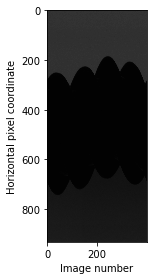

In [2]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

PATH_TO_IMAGE =  '../data_store/2022-10-10_1433_testrecon/cut.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape) # Expect the shape to be in (angles, length, width)

# Generate list of angles for which the sample is expected to rotate
# The last datapoint is excluded 
theta = np.linspace(0, 360, np.shape(im)[0], endpoint=False)

# Convert image stack to sinograms
# Want shape (length, width, angles)
sinogram = np.moveaxis(im, 0, -1)

%matplotlib inline
# Display the sinogram for the first row of pixels
plt.ylabel('Horizontal pixel coordinate')
plt.xlabel('Image number')
io.imshow(sinogram[0])


In [3]:
sinogram[0].shape

(932, 400)

In [4]:
np.sqrt(2)*932


1318.0470401317248

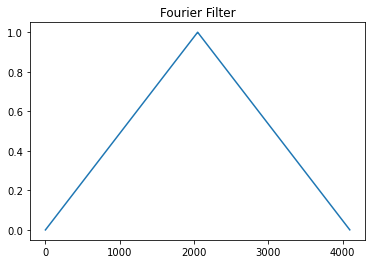

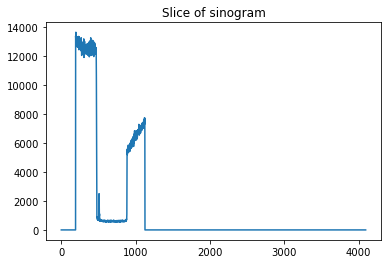

400it [02:39,  2.50it/s]


In [5]:
import numpy as np

from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from scipy.fft import fft, ifft, fftfreq, fftshift, ifft2
from skimage.transform import rotate

from functools import partial

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)


def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.
    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.
    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.
    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    """
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]
    
class iraydon:
    def __init__(self, radon_image, theta, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True):
        """Inverse radon transform.
        Reconstruct an image from the radon transform, using the filtered
        back projection algorithm.
        Parameters
        ----------
        radon_image : array
            Image containing radon transform (sinogram). Each column of
            the image corresponds to a projection along a different
            angle. The tomography rotation axis should lie at the pixel
            index ``radon_image.shape[0] // 2`` along the 0th dimension of
            ``radon_image``.
        theta : array_like, optional
            Reconstruction angles (in degrees). Default: m angles evenly spaced
            between 0 and 180 (if the shape of `radon_image` is (N, M)).
        output_size : int, optional
            Number of rows and columns in the reconstruction.
        filter_name : str, optional
            Filter used in frequency domain filtering. Ramp filter used by default.
            Filters available: ramp, shepp-logan, cosine, hamming, hann.
            Assign None to use no filter.
        interpolation : str, optional
            Interpolation method used in reconstruction. Methods available:
            'linear', 'nearest', and 'cubic' ('cubic' is slow).
        circle : boolean, optional
            Assume the reconstructed image is zero outside the inscribed circle.
            Also changes the default output_size to match the behaviour of
            ``radon`` called with ``circle=True``.
        preserve_range : bool, optional
            Whether to keep the original range of values. Otherwise, the input
            image is converted according to the conventions of `img_as_float`.
            Also see https://scikit-image.org/docs/dev/user_guide/data_types.html
        Returns
        -------
        reconstructed : ndarray
            Reconstructed image. The rotation axis will be located in the pixel
            with indices
            ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.
        .. versionchanged:: 0.19
            In ``iradon``, ``filter`` argument is deprecated in favor of
            ``filter_name``.
        References
        ----------
        .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
            Imaging", IEEE Press 1988.
        .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
            the Discrete Radon Transform With Some Applications", Proceedings of
            the Fourth IEEE Region 10 International Conference, TENCON '89, 1989
        Notes
        -----
        It applies the Fourier slice theorem to reconstruct an image by
        multiplying the frequency domain of the filter with the FFT of the
        projection data. This algorithm is called filtered back projection.
        """


        # Checks and makes sure dimensions and inputs are OK
        if radon_image.ndim != 2:
            raise ValueError('The input image must be 2-D')
        
        self.angles_count = len(theta)

        if self.angles_count != radon_image.shape[1]:
            raise ValueError("The given ``theta`` does not match the number of "
                            "projections in ``radon_image``.")

        interpolation_types = ('linear', 'nearest', 'cubic')
        if interpolation not in interpolation_types:
            raise ValueError(f"Unknown interpolation: {interpolation}")

        filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
        if filter_name not in filter_types:
            raise ValueError(f"Unknown filter: {filter_name}")
        radon_image = radon_image.astype(np.float64)

        self.dtype = radon_image.dtype

        img_shape = radon_image.shape[0]
        if output_size is None:
            # If output size not specified, estimate from input radon image
            if circle:
                output_size = img_shape
            else:
                output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))
        
        
        self.filter_name = filter_name
        self.theta = theta
        self.output_size = output_size
        self.circle = circle
        self.interpolation = interpolation
        self.img_shape = img_shape
        pass

    def transform(self, radon_image):
        # Pads sinogram 
        if self.circle:
            radon_image = _sinogram_circle_to_square(radon_image)
            self.img_shape = radon_image.shape[0]
        
        # Resize image to next power of two (but no less than 64) for
        # Fourier analysis; speeds up Fourier and lessens artifacts
        projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * self.img_shape))))
        pad_width = ((0, projection_size_padded - self.img_shape), (0, 0))
        img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

        # Apply filter in Fourier domain
        fourier_filter = _get_fourier_filter(projection_size_padded, self.filter_name)
        projection = fft(img, axis=0) * fourier_filter

        # plt.plot(fourier_filter)
        # plt.show()

        radon_filtered = np.real(ifft(projection, axis=0)[:self.img_shape, :])
        plt.imshow(radon_filtered)
        plt.show()

        # Reconstruct image by interpolation
        reconstructed = np.zeros((self.output_size, self.output_size),
                                dtype=self.dtype)
        radius = self.output_size // 2
        xpr, ypr = np.mgrid[:self.output_size, :self.output_size] - radius
        x = np.arange(self.img_shape) - self.img_shape // 2

        for col, angle in zip(radon_filtered.T, np.deg2rad(self.theta)):
            t = ypr * np.cos(angle) - xpr * np.sin(angle)
            if self.interpolation == 'linear':
                interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
            else:
                interpolant = interp1d(x, col, kind=self.interpolation,
                                    bounds_error=False, fill_value=0)
            reconstructed += interpolant(t)
            plt.plot(reconstructed[0])
            plt.plot(reconstructed[10])
            plt.show()
            plt.imshow(reconstructed)
            break

        if self.circle:
            out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
            reconstructed[out_reconstruction_circle] = 0.

        return reconstructed * np.pi / (2 * self.angles_count)

    def transform_2dfilter(self, radon_image):
        # If do not want image to be cropped, pad so that a circle is shown
        if self.circle:
            radon_image = _sinogram_circle_to_square(radon_image)
            self.img_shape = radon_image.shape[0]

        # Resize image to next power of two (but no less than 64) for
        # Fourier analysis; speeds up Fourier and lessens artifacts
        projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * self.img_shape))))
        pad_width = ((0, projection_size_padded - self.img_shape), (0, 0))
        img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

        # Reconstruct image by interpolation ######

        radius = self.output_size // 2
        # # Make grid to call interpolant on
        xpr, ypr = np.mgrid[:self.output_size, :self.output_size] - radius
        # # print(xpr, ypr)
        # print('xpr shape', xpr.shape)
        x = np.arange(self.img_shape) - self.img_shape // 2
        
        # Obtain Fourier Transform of sinogram (shape: padded width x N_angles)
        projection = fft(img, axis=0) 

        # plt.title('Sinogram padded before the FT')
        # plt.imshow(img)
        # plt.show()

        # plt.title('FT of Sinogram')
        # plt.imshow(np.log(np.abs(projection)))
        # plt.show()

        reconstructed = np.zeros((self.img_shape, self.img_shape),
                        dtype=self.dtype)

        twod_filter = np.ones((projection_size_padded, projection_size_padded))
        fourier_filter = _get_fourier_filter(projection_size_padded, self.filter_name)[:,0] * twod_filter
        plt.title('Fourier Filter')
        plt.plot(fourier_filter[0])
        # plt.imshow(fourier_filter)
        plt.show()

        plt.title('Slice of sinogram')
        plt.plot(img.T[0])
        plt.show()
        for col, angle in tqdm(zip(projection.T, (self.theta))):
            # plt.title('One Column in the Sinogram')
            # plt.plot(col)
            # plt.show()
            # Extend array to (shape: padded width x padded_width x N_angles)
            # and filter in Fourier Space at the same time
            col_2d = col * fourier_filter
            # plt.title('One Column in the 2D Sinogram')
            # plt.plot(col_2d[3])
            # plt.show()

            # print(col_2d)
            # plt.title('Twod column')
            # plt.imshow(np.abs(col_2d))
            # plt.show()
            # # Transform back to real space
            radon_filtered = np.real(ifft(col_2d, axis=1)[:self.img_shape, :self.img_shape])
            # plt.plot(radon_filtered[0])
            # plt.show()
            
            reconstructed += rotate(radon_filtered, angle)

        # if self.circle:
        #     out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        #     reconstructed[out_reconstruction_circle] = 0.
        # return radon_filtered
        return reconstructed * np.pi / (2 * self.angles_count)

inv = iraydon(sinogram[0,:,::1], theta[::1], filter_name='ramp', circle=True)


projection = inv.transform_2dfilter(sinogram[0,:,::1])
# projection = inv.transform(sinogram[0])

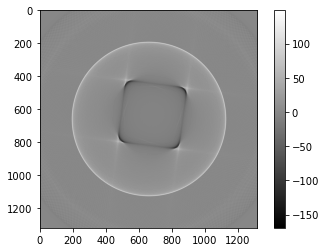

In [6]:
plt.imshow(projection, cmap='gray')
plt.colorbar()

In [124]:
sinogram[0,:,::20].shape

(932, 20)

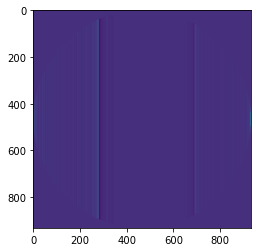

In [104]:
plt.imshow(projection)

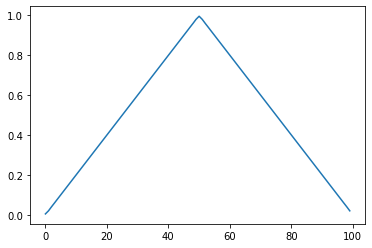

In [31]:
plt.plot(_get_fourier_filter(100, 'ramp'))

In [6]:
def twod_gaus(size):
    X = np.arange(-size//2, size//2)
    
    return X
def deconvolve_with_depth(im_array):
    # FT array
    # Divide by depth dependent MTF (assume it to be a Gaussian)
    # 
    return

twod_gaus(10)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [7]:
inv = iraydon(sinogram[0], theta, filter_name='hamming', circle=True)

# Reconstruct dataset here
reconstruction_fbp = np.zeros((im.shape[1], im.shape[2], im.shape[2]))
# reconstruction_fbp = np.zeros((im.shape[1], 659, 659))
# for i in tqdm(range(im.shape[1])):
for i in tqdm(range(1)):
    reconstruction_fbp[i] = inv.transform_2dfilter(sinogram[i])

100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


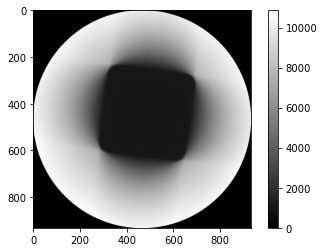

In [29]:
plt.imshow(reconstruction_fbp[0], cmap='gray')
plt.colorbar()

In [37]:
sinogram[0].shape

(932, 400)

In [38]:
width = 932
twod_filter = np.zeros((width, width))
